# WORKFLOW Using Langgraph

In [1]:
import pandas as pd 
import os
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage
from typing import Annotated ,Literal
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

load_dotenv()

True

In [2]:
api_key = os.getenv("GOOGLE_API_KEY")

In [3]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=api_key
)

In [ ]:
# This is a fixed and improved version of your agent with a feedback loop.

from typing import TypedDict, List
from langgraph.graph import StateGraph, END

# Define the state of the graph.
# 'feedback' is a new field to store the result of the human evaluation.
class QueryState(TypedDict):
    """Represents the state of our agent's workflow with feedback."""
    query: str
    documents: List[str]
    answer: str
    feedback: str # New field to store feedback ("satisfied" or "not_satisfied")

# Define the nodes (functions) for the graph.

def document_rag(state: QueryState) -> QueryState:
    """Retrieves documents based on the query. 
    
    In a real system, this could change the retrieval strategy or search a new data source
    if the previous attempt failed. For this example, we'll simulate returning different docs
    on subsequent loops.
    """
    print("Executing: Document Retrieval...")
    
    # Simple logic to simulate getting different documents on a retry.
    if "feedback" in state and state["feedback"] == "not_satisfied":
        print("Retrying search with a different strategy...")
        retrieved_docs = ["Document chunk about customer support channels.",
                          "Document chunk about the escalation process."]
    else:
        retrieved_docs = ["Document chunk about the company's return policy.",
                          "Document chunk detailing product warranty information."]
                          
    return {"documents": retrieved_docs}

def relevant_answer(state: QueryState) -> QueryState:
    """Generates an answer using the retrieved documents."""
    print("Executing: Generating Answer...")
    
    docs = state.get("documents", [])
    query = state.get("query", "")
    
    # Simple placeholder for the LLM's response
    # In a real app, this would use an LLM with the retrieved context.
    if docs:
      answer = f"Based on the provided documents: '{docs[0]}', I can answer your query: '{query}'."
    else:
      answer = "I could not find a relevant document to answer your query."
    return {"answer": answer}

def human_evalution(state: QueryState) -> QueryState:
    """Simulates a human evaluation node and decides the next step.
    
    This function acts as a conditional check. In a real application, this would
    be a user action (e.g., clicking a "thumbs up" or "thumbs down" button).
    """
    print("Executing: Human Evaluation...")
    print(f"Agent's Answer: {state.get('answer')}")
    
    # Simulate a user's feedback. For the first run, let's say the user is not satisfied.
    # On a subsequent run, we can pretend they are satisfied to demonstrate the loop ending.
    if state.get("feedback") == "not_satisfied":
        print("Simulated feedback: User is now satisfied.")
        feedback = "satisfied"
    else:
        print("Simulated feedback: User is not satisfied.")
        feedback = "not_satisfied"
        
    return {"feedback": feedback}

# --- Build the LangGraph workflow ---

# Define a function to act as our conditional router.
# It returns the name of the next node based on the feedback.
def check_feedback(state: QueryState) -> str:
    """Decides whether to continue the loop or end."""
    if state.get("feedback") == "satisfied":
        print("Decision: Feedback is positive. Ending the conversation.")
        return "end"
    else:
        print("Decision: Feedback is negative. Looping back to document retrieval.")
        return "continue"

# Build the LangGraph workflow.
graph = StateGraph(QueryState)

# Add the nodes to the graph.
graph.add_node("Document_rag", document_rag)
graph.add_node("relevent_ans", relevant_answer)
graph.add_node("human_evalution", human_evalution)


graph.set_entry_point("Document_rag")


graph.add_edge("Document_rag", "relevent_ans")
graph.add_edge("relevent_ans", "human_evalution")


graph.add_conditional_edges(
    "human_evalution",
    check_feedback,
    {
        "continue": "Document_rag", 
        "end": END,                
    }
)

app = graph.compile()




In [10]:
# --- Example Usage ---
# The agent will now run in a loop until the simulated feedback is "satisfied".
initial_state = {"query": "Tell me about the return policy."}
print("\n--- Starting the agent with feedback loop ---")

# We can run it once or invoke it in a loop to see the behavior.
# Here, we'll use a for loop to demonstrate the feedback mechanism.
current_state = initial_state
for i in range(3): # Run for a max of 3 iterations
    print(f"\n--- Iteration {i+1} ---")
    current_state = app.invoke(current_state)
    if current_state.get("feedback") == "satisfied":
        break

print("\nFinal State:", current_state)


--- Starting the agent with feedback loop ---

--- Iteration 1 ---
Executing: Document Retrieval...
Executing: Generating Answer...
Executing: Human Evaluation...
Agent's Answer: Based on the provided documents: 'Document chunk about the company's return policy.', I can answer your query: 'Tell me about the return policy.'.
Simulated feedback: User is not satisfied.
Decision: Feedback is negative. Looping back to document retrieval.
Executing: Document Retrieval...
Retrying search with a different strategy...
Executing: Generating Answer...
Executing: Human Evaluation...
Agent's Answer: Based on the provided documents: 'Document chunk about customer support channels.', I can answer your query: 'Tell me about the return policy.'.
Simulated feedback: User is now satisfied.
Decision: Feedback is positive. Ending the conversation.

Final State: {'query': 'Tell me about the return policy.', 'documents': ['Document chunk about customer support channels.', 'Document chunk about the escalatio

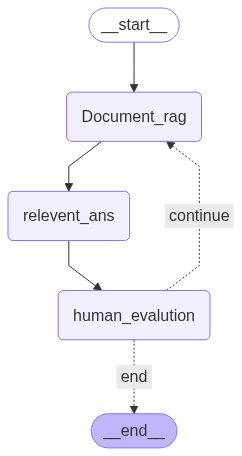

In [9]:
app

In [4]:
llm.invoke("Hello, how are you?")

AIMessage(content='I am doing well, thank you for asking!  How are you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--d326fee9-2031-4d50-8149-85f15c565ab2-0', usage_metadata={'input_tokens': 6, 'output_tokens': 17, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
from typing import Annotated ,Literal
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [6]:
class State(TypedDict):
    message: Annotated[list, add_messages]

In [7]:
graph = StateGraph(State)

In [8]:
def chatbot(state: State):
    return {"message": [llm.invoke(state["message"])]}

In [9]:
graph.add_node("chatbot",chatbot)

In [10]:
graph.add_edge(START,"chatbot")
graph.add_edge("chatbot",END)

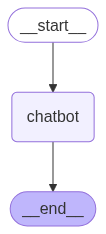

In [11]:
app = graph.compile()
app

In [14]:
from langchain_core.messages import HumanMessage

output = app.invoke({
    "message": [HumanMessage(content="Hello, how are you?")]
})

print(output["message"][-1].content)


I'm doing well, thank you for asking! How are you today?


In [19]:
output

{'message': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='e1039a17-03a6-4bd2-b301-fc550a6f275d'),
  AIMessage(content="I'm doing well, thank you for asking! How are you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--85fef8d8-207a-4cfc-92bc-d18ae72587b6-0', usage_metadata={'input_tokens': 6, 'output_tokens': 17, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})]}

In [17]:
# def stream_graph_updates(user_input: str):
#     for event in app.invoke({"messages": [{"role": "user", "content": user_input}]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)

def stream_graph_updates(user_input: str):
    for event in app.invoke({"message": [HumanMessage(content=user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)



In [18]:

while True:
    try:
        user_input = 'Hello, how are you?'
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?


AttributeError: 'str' object has no attribute 'values'